In [1]:
import findspark
findspark.init()

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.sql.functions import explode, split
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.sql.functions import udf

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
txt_files = os.listdir('labeledData')
articles = []
labels = []
for file in txt_files:
    with open(f'labeledData/{file}', encoding='utf-8') as f:
        text = f.read()
        lines = text.split('\n')
        articles.append(lines[3])
        labels.append(lines[1][1:])

In [16]:
articles_df = pd.DataFrame(np.array([articles, labels]).T, columns=['article', 'label'])

In [17]:
set(labels)

{'business',
 'entertainment',
 'health',
 'politics',
 'sport',
 'style',
 'travel',
 'world'}

In [18]:
label_dict = {'business': 0,
               'entertainment': 1,
               'health': 2,
               'politics': 3,
               'sport': 4,
               'style': 5,
               'travel': 6,
               'world': 7}


In [19]:
articles_df['label'] = articles_df['label'].apply(lambda x: label_dict[x])
articles_df

,article,label
0,"Boston-based travelers, you’re in for a treat....",0
1,Nordstrom. Walmart. Whole Foods. Starbucks. CV...,0
2,An ex-ByteDance employee claimed he was wrongf...,0
3,"Pickleball is coming to your local mall, repla...",0
4,Leaders in Washington are running out of time ...,0
...,...,...
366,The NBA’s Phoenix Suns have fired head coach M...,7
367,"Growing up, Yasmine Arrington’s father was in ...",7
368,"May is Mental Health Awareness Month, and this...",7
369,Russia’s invasion of Ukraine triggered a flood...,7


#### K-Means Clustering using Tf-Idf

In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(articles_df.article)

In [21]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Evaluate the clustering results
silhouette_avg = silhouette_score(X, labels)
print(f"Average silhouette score: {silhouette_avg}")

Average silhouette score: -0.002550053422332115


In [22]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([  3,  25, 312,  13,   2,   7,   5,   4], dtype=int64))

The silhouette score is a metric used to evaluate the quality of clustering results. It measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a higher score indicates better clustering performance:

- A score close to +1 indicates that the samples are well-clustered, with a high level of cohesion within clusters and a clear separation between clusters.
- A score close to 0 indicates overlapping or ambiguous clusters.
- A score close to -1 indicates that the samples may have been assigned to the wrong clusters.

The silhouette score is calculated for each sample and then averaged to obtain the average silhouette score for the entire dataset.

The formula to calculate the silhouette score for a single sample `i` is as follows:

s(i) = (b(i) - a(i)) / max(a(i), b(i))

Where:
- `a(i)` is the average distance between sample `i` and all other samples within the same cluster.
- `b(i)` is the average distance between sample `i` and all samples in the nearest neighboring cluster.

The overall silhouette score is calculated by taking the mean of all silhouette scores for each sample.

In [23]:
def plot(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar()
    plt.show()

#### K-Means clustering using GloVe Word Embeddings

In [28]:
import gensim.downloader as api

In [29]:
glove_embeddings = api.load("glove-wiki-gigaword-300")

In [33]:
article_embeddings = []

# Convert each article to a feature vector using GloVe embeddings
for article in articles:
    # Initialize an empty array to store word embeddings for the current article
    word_embeddings = []

    # Split the article into individual words
    words = article.split()

    # Iterate over each word in the article
    for word in words:
        # Retrieve the GloVe embedding vector for the word
        if word in glove_embeddings:
            word_embedding = glove_embeddings[word]
            word_embeddings.append(word_embedding)

    # If no words in the article have GloVe embeddings, assign a random vector
    if len(word_embeddings) == 0:
        # Assuming GloVe vectors have 300 dimensions
        word_embeddings.append(np.random.rand(300))

    # Combine the word embeddings to obtain the article embedding
    # Use mean or sum depending on your preference
    article_embedding = np.mean(word_embeddings, axis=0)
    article_embeddings.append(article_embedding)


In [34]:
# Convert the list of article embeddings to a NumPy array
X = np.array(article_embeddings)

kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)

labels = kmeans.labels_

Average silhouette score: 0.09959038347005844


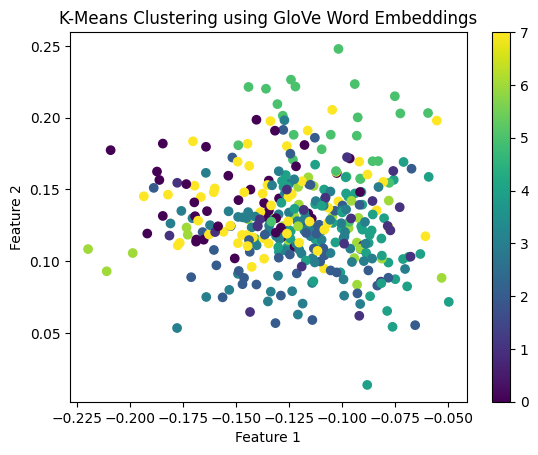

In [35]:
# Evaluate the clustering results
silhouette_avg = silhouette_score(X, labels)
print(f"Average silhouette score: {silhouette_avg}")

plot(X, labels, 'K-Means Clustering using GloVe Word Embeddings')

We get slightly better score using Glove word encoding

#### DBSCAN Clustering

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


In [37]:
np.unique(articles_df.label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([52, 45, 32, 47, 43, 56, 42, 54], dtype=int64))

In [38]:
dbscan = DBSCAN(eps=0.62, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_

silhouette_avg = silhouette_score(X, labels)
print(f"Average silhouette score: {silhouette_avg}")

np.unique(labels, return_counts=True)

Average silhouette score: 0.034380123019218445


(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([ 51, 306,   4,   2,   2,   4,   2], dtype=int64))

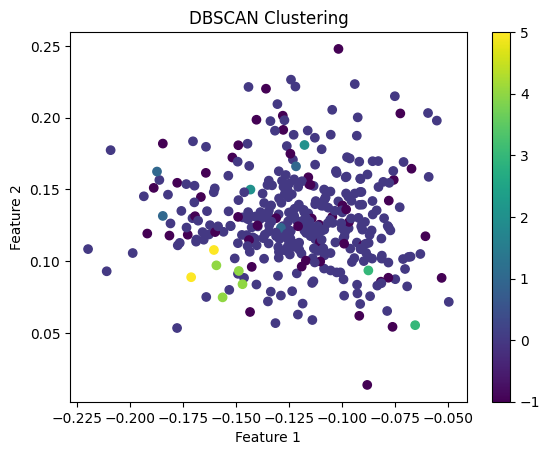

In [39]:
plot(X, labels, 'DBSCAN Clustering')

#### LDA (Latent Dirichlet Allocation)

In [40]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel


In [41]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In the code snippet below, we use the simple_preprocess function from Gensim's utils module to tokenize and preprocess the documents. This function performs basic preprocessing steps like lowercasing, tokenizing, and removing punctuation.

In [42]:
tokenized_docs = [[token for token in simple_preprocess(
    doc) if token not in STOPWORDS] for doc in articles_df.article]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(tokenized_docs)

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Apply LDA model to the corpus
lda_model = gensim.models.LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=8, passes=10)


In [43]:
# Print the top topics and their associated keywords
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Assign the most probable topic to each document
for i, doc in enumerate(corpus):
    topic_probs = lda_model.get_document_topics(doc)
    dominant_topic = max(topic_probs, key=lambda x: x[1])


(0, '0.012*"said" + 0.008*"people" + 0.006*"trans" + 0.005*"drag" + 0.004*"women" + 0.003*"swimming" + 0.003*"year" + 0.003*"time" + 0.003*"like" + 0.003*"templer"')
(1, '0.013*"said" + 0.004*"new" + 0.004*"year" + 0.003*"people" + 0.003*"time" + 0.003*"health" + 0.003*"states" + 0.003*"gaza" + 0.003*"israel" + 0.002*"mental"')
(2, '0.012*"trump" + 0.010*"said" + 0.005*"president" + 0.005*"collins" + 0.004*"people" + 0.004*"new" + 0.004*"cnn" + 0.004*"like" + 0.003*"know" + 0.003*"time"')
(3, '0.012*"said" + 0.005*"people" + 0.004*"new" + 0.003*"like" + 0.003*"year" + 0.003*"time" + 0.002*"google" + 0.002*"ai" + 0.002*"years" + 0.002*"lupus"')
(4, '0.008*"said" + 0.004*"people" + 0.004*"women" + 0.004*"time" + 0.003*"year" + 0.003*"new" + 0.003*"years" + 0.003*"like" + 0.003*"health" + 0.002*"city"')
(5, '0.008*"said" + 0.005*"says" + 0.005*"time" + 0.005*"year" + 0.004*"world" + 0.004*"people" + 0.004*"years" + 0.003*"concorde" + 0.003*"workers" + 0.003*"like"')
(6, '0.012*"said" + 0.

In [44]:
log_perplexity = lda_model.log_perplexity(corpus)

print(f"Log Perplexity: {log_perplexity}")

# Calculate the coherence score using the c_v coherence measure
coherence_model = CoherenceModel(
    model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score}")


Log Perplexity: -8.962986321566934
Coherence Score: 0.28597579981280935


Perplexity measures how well the model predicts the observed data. Lower perplexity values indicate better model performance. The log perplexity is a negative number, and the closer it is to 0, the better.

Coherence measures the interpretability and semantic coherence of the topics generated by the model. It evaluates how well the top words in a topic are related and how distinct the topics are from each other. You can use the CoherenceModel class in Gensim to calculate the coherence score of your LDA model. Common coherence metrics include UMass coherence and c_v coherence.

### Supervised Clustering

#### SVM Classification

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [52]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

In [53]:
articles_df['article_preprocessed'] = articles_df['article'].apply(preprocess)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    articles_df['article_preprocessed'], articles_df['label'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [55]:
model = LinearSVC()
model.fit(X_train_vectorized, y_train)

LinearSVC()

In [56]:
predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {round(accuracy*100, 2)}%")


Accuracy: 65.33%


In [57]:
y_test.to_numpy(), predictions

(array([7, 0, 0, 6, 1, 5, 1, 2, 6, 2, 5, 0, 3, 1, 3, 6, 0, 5, 7, 2, 0, 4,
        1, 5, 5, 3, 5, 4, 4, 7, 0, 2, 0, 7, 6, 2, 1, 0, 3, 4, 5, 6, 0, 5,
        2, 2, 1, 1, 0, 0, 7, 3, 6, 4, 5, 7, 1, 0, 7, 1, 3, 6, 1, 0, 5, 1,
        5, 7, 4, 1, 1, 4, 6, 6, 7], dtype=int64),
 array([2, 0, 0, 7, 1, 5, 1, 7, 6, 0, 5, 3, 3, 0, 3, 7, 6, 5, 7, 2, 7, 4,
        1, 2, 0, 3, 5, 4, 4, 4, 3, 2, 0, 6, 6, 7, 1, 0, 3, 4, 7, 0, 0, 7,
        0, 2, 1, 1, 0, 0, 7, 3, 7, 4, 5, 0, 1, 0, 7, 1, 3, 1, 1, 1, 5, 7,
        5, 7, 4, 1, 1, 6, 7, 6, 7], dtype=int64))

#### Multinomial Naive Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB

In [59]:
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Step 5: Make Predictions
predictions = model.predict(X_test_vectorized)

# Step 6: Evaluate the Model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {round(accuracy*100, 2)}%")

Accuracy: 69.33%
